# **Análisis Avanzado de Clientes: PCA y Segmentación Basada en CLTV a 5 Años.**
El objetivo de este análisis es identificar segmentos de clientes con comportamientos y características homogéneas, utilizando técnicas de Machine Learning no supervisadas. Para ello, se ha implementado un proceso de reducción de dimensionalidad mediante **Análisis de Componentes Principales (PCA)** y un algoritmo de clustering basado en **K-Means**.

El foco principal del estudio es la variable **Customer Lifetime Value (CLTV)** estimada a 5 años, con el propósito de optimizar estrategias de fidelización y maximización del valor del cliente para la compañía. El flujo del análisis es el siguiente:

1. Selección y preparación de variables predictivas.
2. Escalado y estandarización de datos.
3. Aplicación de PCA para reducir la dimensionalidad.
4. Determinación óptima del número de clusters (Elbow Method).
5. Implementación del modelo de clustering K-Means.
6. Análisis descriptivo y perfilado de los clusters en relación con el CLTV a 5 años.

## **Importación de librerías y configuración general.**
Se cargan las librerías necesarias (incluidas en el archivo `requirements.txt`) para trabajar con bases de datos, manipulación de datos y archivos. También se desactivan ciertos mensajes de advertencia que podrían ensuciar la salida.

In [37]:
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import urllib
import sqlalchemy
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)

## **Conexión a la base de datos.**
Interfaz establecida con la base de datos local que contiene el modelo estrella consolidado. Este entorno almacena las tablas de hechos y dimensiones, así como la tabla `clients_insights`, utilizada como dataset base del modelo.

In [38]:
# SQL Server (entorno local)
LOCAL_SERVER = 'localhost'
LOCAL_DATABASE = 'dwh_case1'
LOCAL_DRIVER = '{ODBC Driver 17 for SQL Server}'

# Construcción de cadena de conexión
local_conn_str = f"DRIVER={LOCAL_DRIVER};SERVER={LOCAL_SERVER};DATABASE={LOCAL_DATABASE};Trusted_Connection=yes;TrustServerCertificate=yes"
conn = pyodbc.connect(local_conn_str)

In [39]:
df = pd.read_sql_query("SELECT * FROM client_insights", conn)
df.set_index('Customer_ID', inplace=True)
df.head()

,Edad,GENERO,STATUS_SOCIAL,RENTA_MEDIA_ESTIMADA,ENCUESTA_ZONA_CLIENTE_VENTA,ENCUESTA_CLIENTE_ZONA_TALLER,total_quejas,CODIGO_POSTAL,poblacion,provincia,lat,lon,Segmento_Principal,numventas,pvp_medio,coste_medio_sin_impuestos,descuento_medio,avg_revisiones,ratio_edad_rev,km_rev,km_rev_max,dias_ultima_rev_max,avg_dias_taller,ratio_en_garantia,lead_algunavez,lead_compra,margenbruto_pu,margen_total,margen_pu,edad_ultimocoche,edad_promedio_coches,max_coches,ingresos_totales,impuestos_totales,primera_compra,ultima_compra,dias_relacion,avg_dias_produccion_venta,churn_estimado,retencion_estimado,CLTV_1_anio,CLTV_2_anios,CLTV_3_anios,CLTV_4_anios,CLTV_5_anios
Customer_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,47,M,H,25641,137,146,0,08470,Campins,Barcelona,2.463162,41.724785,H,1,18579,1529,-1115,0,0,0,0,0.0,0.0,1,1,1,6131.069824,2865.750000,2865.750000,0.0,0.0,PB100069,18579,0,2023-01-02,2023-01-02,0,125,0.283154,0.716846,1919.909141,3206.152222,4067.870742,4645.179043,5031.946725
7,36,F,NA,0,0,0,0,47009,Valladolid,Valladolid,-4.723349,41.652328,C,1,15195,864,-1658,0,0,0,0,0.0,0.0,0,1,0,4254.600098,1925.000000,1925.000000,4.0,4.0,PA100039,15195,0,2019-07-24,2019-07-24,0,67,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,39,M,NA,0,0,0,0,03130,Santa Pola,Alicante/Alacant,-0.555281,38.193115,C,1,30330,1034,-2833,0,0,0,0,0.0,0.0,1,0,0,13041.900391,11151.299805,11151.299805,1.0,1.0,PI100395,30330,0,2022-04-12,2022-04-12,0,83,0.391498,0.608502,6341.666326,9948.127679,11999.097066,13165.469034,13828.776626
11,53,M,NA,0,0,0,0,08711,Òdena,Barcelona,1.638468,41.605412,H,1,30330,1034,-2833,0,0,0,0,0.0,0.0,1,1,0,13041.900391,11151.299805,11151.299805,1.0,1.0,PI100395,30330,0,2022-03-03,2022-03-03,0,108,0.391498,0.608502,6341.666326,9948.127679,11999.097066,13165.469034,13828.776626
12,47,M,G,27287,121,12,0,17006,Girona,Girona,2.824119,41.981861,G,1,12656,597,-2019,2,23,56912,56912,960.0,0.0,0,0,0,3543.679932,1684.199951,1684.199951,4.0,4.0,PA100044,12656,0,2019-02-23,2019-02-23,0,64,0.262646,0.737354,1160.608694,1960.402413,2511.552852,2891.359295,3153.089893


In [40]:
df.describe()

,Edad,RENTA_MEDIA_ESTIMADA,ENCUESTA_ZONA_CLIENTE_VENTA,ENCUESTA_CLIENTE_ZONA_TALLER,total_quejas,lat,lon,numventas,pvp_medio,coste_medio_sin_impuestos,descuento_medio,avg_revisiones,ratio_edad_rev,km_rev,km_rev_max,dias_ultima_rev_max,avg_dias_taller,ratio_en_garantia,lead_algunavez,lead_compra,margenbruto_pu,margen_total,margen_pu,edad_ultimocoche,edad_promedio_coches,ingresos_totales,impuestos_totales,dias_relacion,avg_dias_produccion_venta,churn_estimado,retencion_estimado,CLTV_1_anio,CLTV_2_anios,CLTV_3_anios,CLTV_4_anios,CLTV_5_anios
count,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.0,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000,44053.000000
mean,42.840873,21881.461104,60.529907,63.742537,0.175289,-2.879594,39.853260,1.317708,23568.301273,1258.644633,-1946.142987,0.916169,16.450911,34328.777881,40996.540440,168.313395,3.115091,0.629174,0.620730,0.159013,8112.239176,4859.915905,3695.833984,2.360520,2.077420,31049.047874,0.0,209.888407,96.180056,0.328867,0.671133,2206.411781,3856.899735,5170.447613,6257.555485,7181.928033
std,10.735030,12538.549499,55.429850,57.675906,0.396812,3.965694,4.779973,0.586814,5475.685304,684.696870,1617.854023,1.122719,19.284873,42468.883356,48700.450771,276.179559,4.567018,0.483031,0.485211,0.365692,3001.893711,5597.098793,4192.451367,1.753997,1.608172,15363.758997,0.0,450.406181,17.348108,0.314400,0.314400,3243.550990,6020.412700,8478.616592,10694.604407,12714.828602
min,20.000000,0.000000,0.000000,0.000000,0.000000,-17.981152,0.000000,1.000000,10528.000000,0.000000,-32866.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1391.099976,-16051.290039,-9988.679688,0.000000,0.000000,10528.000000,0.0,0.000000,35.000000,0.000000,0.000000,-8681.009054,-16794.101627,-24376.431135,-31462.720395,-38085.420638
25%,34.000000,20036.000000,1.000000,1.000000,0.000000,-4.560451,39.149448,1.000000,19994.000000,871.000000,-2382.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6351.180176,1373.599976,1179.599976,1.000000,1.000000,20841.000000,0.0,0.000000,86.000000,0.000000,0.486601,252.167684,369.052660,433.267854,460.931714,481.538576
50%,42.000000,26463.000000,63.000000,68.000000,0.000000,-3.434904,40.541042,1.000000,23547.000000,1196.000000,-1681.000000,1.000000,9.000000,23145.000000,30379.000000,40.000000,0.000000,1.000000,1.000000,0.000000,7886.669922,3376.250000,2785.750000,2.000000,2.000000,26448.000000,0.0,0.000000,97.000000,0.257215,0.742785,1389.249260,2267.785544,2816.415851,3185.455146,3461.431599
75%,51.000000,30050.000000,111.000000,113.000000,0.000000,-0.231929,41.869236,2.000000,27332.000000,1584.000000,-1122.000000,1.000000,32.000000,50843.000000,60038.000000,214.000000,6.000000,1.000000,1.000000,0.000000,10151.153320,9376.820312,6062.240173,4.000000,3.500000,35826.000000,0.0,54.000000,109.000000,0.513399,1.000000,3371.250383,5829.366957,7784.011285,9311.842311,10447.590361
max,78.000000,37777.000000,356.000000,276.000000,3.000000,4.265466,43.740353,6.000000,37970.000000,7052.000000,0.000000,8.000000,78.000000,376640.000000,376640.000000,1731.000000,129.000000,1.000000,1.000000,1.000000,15811.530273,41769.080078,14265.639648,5.000000,5.000000,164898.000000,0.0,2179.000000,157.000000,1.000000,1.000000,13314.747919,25758.437563,37388.054053,48256.854511,58414.611948


In [41]:
df = df.select_dtypes(include=['number']) # Unicamente variables numéricas.

## **Análisis exploratorio inicial.**
Antes de proceder con la aplicación de técnicas de reducción de dimensionalidad y segmentación, es imprescindible realizar un análisis exploratorio de los datos disponibles. Esta fase permite comprender la estructura y comportamiento de las variables, identificar posibles inconsistencias, y detectar relaciones que puedan afectar a los modelos posteriores.

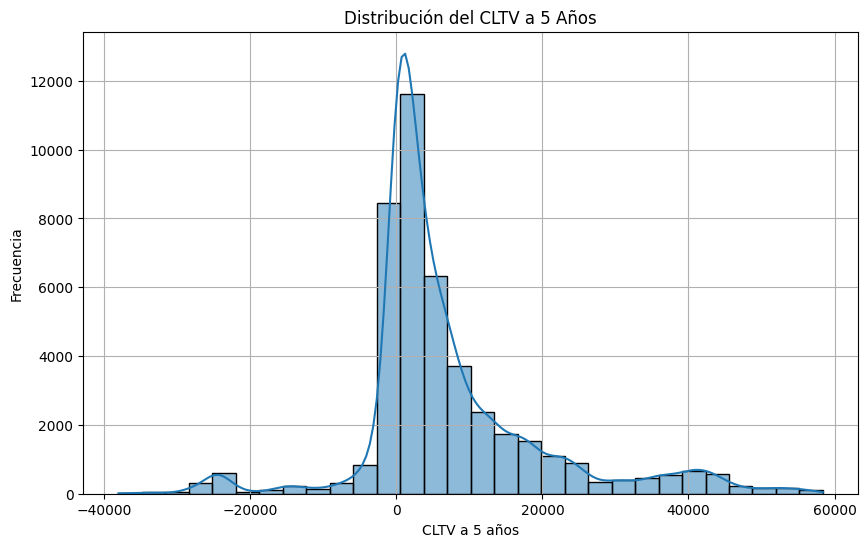

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(df['CLTV_5_anios'], bins=30, kde=True)
plt.title('Distribución del CLTV a 5 Años')
plt.xlabel('CLTV a 5 años')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

### **Matriz de correlación.**
Antes de aplicar un PCA, es fundamental revisar la matriz de correlación entre las variables numéricas, ya que la presencia de variables altamente correlacionadas puede afectar tanto la interpretación de los componentes como la eficiencia del modelo. El tratamiento habitual según el grado de correlación es el siguiente:
- **Correlación Perfecta:** Cuando dos variables presentan una correlación perfecta, significa que una de ellas es una copia exacta o una transformación lineal de la otra. En este caso, **una de las dos variables debe ser eliminada**, ya que aporta información redundante y no contribuye al análisis.

- **Correlación Muy Alta:** Si la correlación entre dos variables es superior a 0.9 (o un umbral similar, como 0.85 o 0.95, según el criterio del analista), se considera que estas variables contienen información muy similar. Aunque el PCA está diseñado para gestionar colinealidades, **mantener variables excesivamente correlacionadas puede sobrerrepresentar un mismo patrón de variabilidad**. Por este motivo, es recomendable revisar cada caso y considerar la eliminación de una de las dos variables, especialmente si no aporta un valor añadido desde el punto de vista interpretativo o de negocio.

- **Correlación Moderada:** Las variables con correlación moderada pueden mantenerse, ya que aportan información complementaria y el PCA podrá capturar sus relaciones lineales y redistribuir la varianza entre los componentes principales.

- **Correlación Baja o Nula:** Las variables con poca o ninguna correlación aportan información independiente y son ideales para el PCA, ya que contribuyen a la diversidad de los datos y aumentan la capacidad explicativa del modelo.

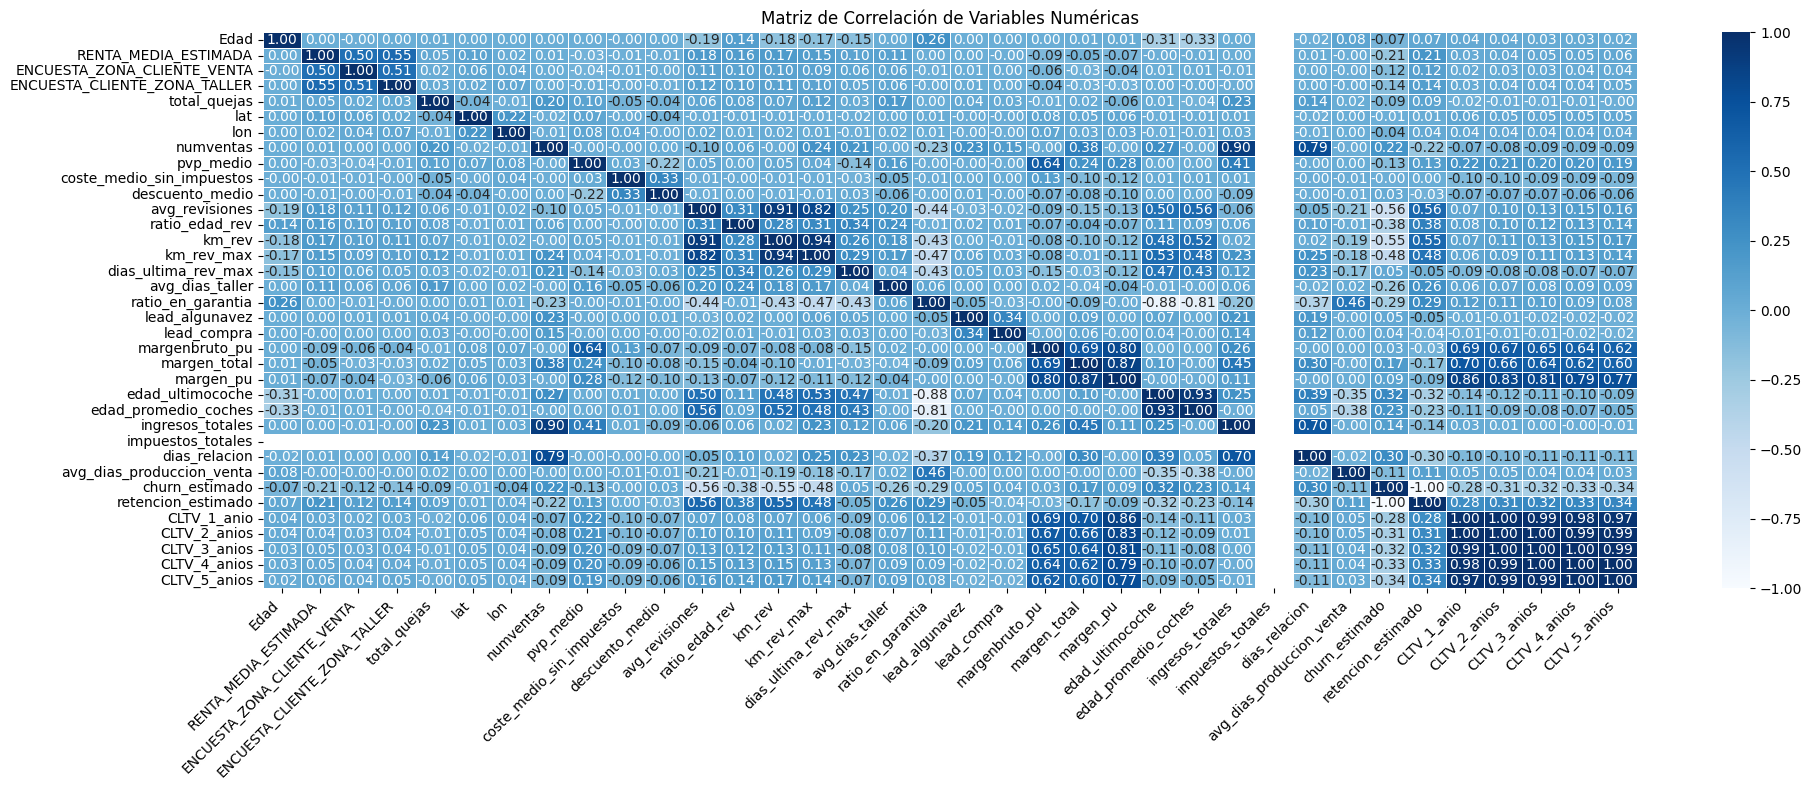

In [43]:
plt.figure(figsize=(20, 8))
sns.heatmap(df.corr(), cmap='Blues', center=0, annot=True, fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Aunque en el análisis se realizó una matriz de correlación para identificar relaciones entre variables, **no se eliminaron aquellas con alta correlación, ya que el PCA aplicado posteriormente se encarga de condensar dicha información redundante en los componentes principales**. Por tanto, la colinealidad no afecta al clustering posterior, ya que el K-Means se aplica sobre los componentes ortogonales generados por el PCA.

### **Boxplots de variables relevantes.**
Se han elaborado boxplots de las variables numéricas con el objetivo de analizar su distribución y detectar la presencia de posibles outliers. Este análisis previo permite identificar variables con alta dispersión o valores extremos que podrían influir en los resultados posteriores.

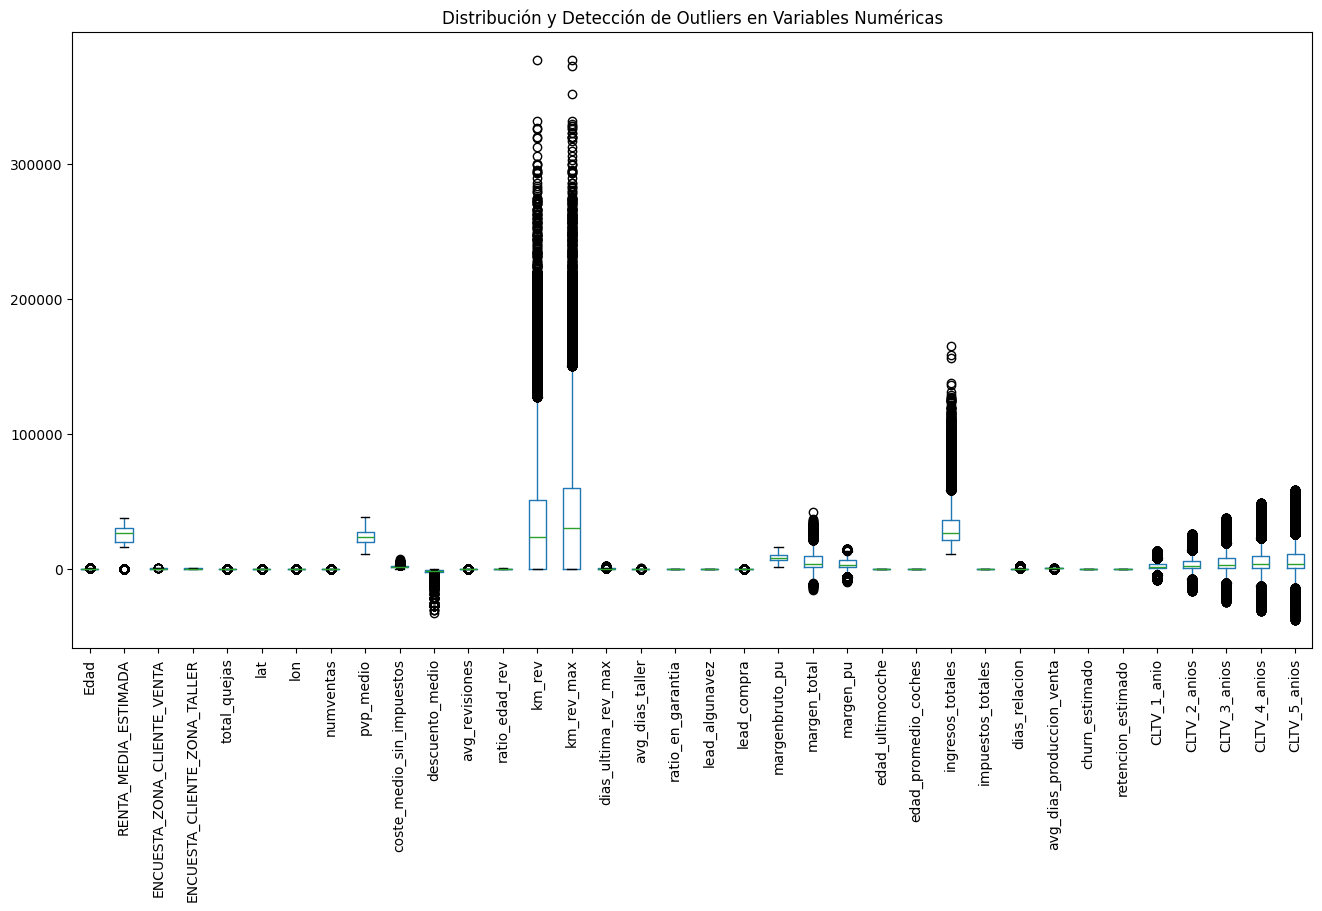

In [44]:
plt.figure(figsize=(16, 8))
df.boxplot(rot=90)
plt.title('Distribución y Detección de Outliers en Variables Numéricas')
plt.grid()
plt.show()

La visualización mediante boxplots ha evidenciado la **existencia de múltiples outliers** en las variables numéricas. No obstante, **estos valores no serán eliminados**, ya que el análisis principal se realizará mediante PCA, técnica que absorbe parte de la variabilidad generada por los outliers al condensar la información en los componentes principales. Además, para evitar que las diferencias de escala entre variables afecten al resultado, se aplicará un **proceso de estandarización previo** al análisis. Finalmente, se revisará el comportamiento de los outliers una vez realizados el PCA y el clustering, para evaluar si estos casos extremos influyen en la formación de los grupos.

### **Gráficos de dispersión de un par de variables correlacionadas.**
Con el objetivo de complementar el análisis de la matriz de correlación, se han elaborado gráficos de dispersión entre aquellas variables numéricas que presentan una correlación elevada. Este análisis visual permite confirmar la existencia de relaciones lineales entre variables, identificar patrones claros de dependencia y detectar posibles redundancias de información. Además, facilita la interpretación de la estructura de los datos antes de aplicar técnicas de reducción de dimensionalidad como el PCA.

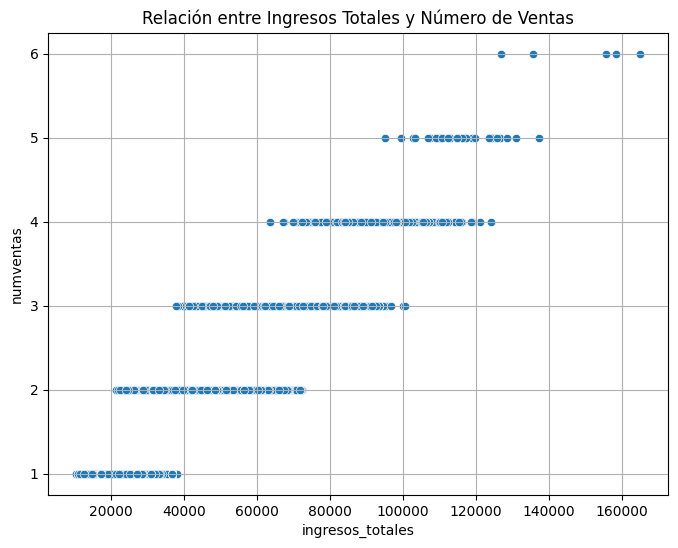

In [45]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='ingresos_totales', y='numventas')
plt.title('Relación entre Ingresos Totales y Número de Ventas')
plt.grid()
plt.show()

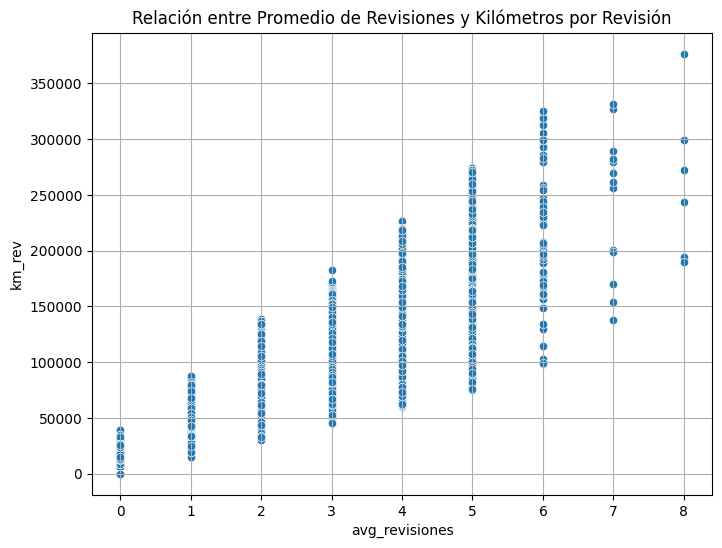

In [46]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='avg_revisiones', y='km_rev')
plt.title('Relación entre Promedio de Revisiones y Kilómetros por Revisión')
plt.grid()
plt.show()

Los gráficos de dispersión muestran **relaciones lineales claras** entre las variables analizadas. Por un lado, se observa una relación positiva entre los ingresos totales y el número de ventas, lo que confirma que **a mayor cantidad de ventas, mayores son los ingresos generados**. Por otro lado, existe también una relación creciente entre el promedio de revisiones y los kilómetros recorridos por revisión, indicando que **los clientes con más revisiones suelen acumular un mayor kilometraje**.

Estas relaciones justifican la alta correlación detectada previamente y refuerzan la necesidad de aplicar técnicas de reducción de dimensionalidad para evitar la duplicación de información en el análisis.

## **Selección de variables predictivas.**
En este apartado se realiza la selección de las variables numéricas relevantes para el análisis. Previamente, se han **excluido las variables de tipo object y categóricas, así como identificadores, fechas y métricas objetivo (CLTV)**. Se han conservado únicamente aquellas variables que describen el perfil sociodemográfico y el comportamiento histórico de los clientes.

In [47]:
df.columns

Index(['Edad', 'RENTA_MEDIA_ESTIMADA', 'ENCUESTA_ZONA_CLIENTE_VENTA',
       'ENCUESTA_CLIENTE_ZONA_TALLER', 'total_quejas', 'lat', 'lon',
       'numventas', 'pvp_medio', 'coste_medio_sin_impuestos',
       'descuento_medio', 'avg_revisiones', 'ratio_edad_rev', 'km_rev',
       'km_rev_max', 'dias_ultima_rev_max', 'avg_dias_taller',
       'ratio_en_garantia', 'lead_algunavez', 'lead_compra', 'margenbruto_pu',
       'margen_total', 'margen_pu', 'edad_ultimocoche', 'edad_promedio_coches',
       'ingresos_totales', 'impuestos_totales', 'dias_relacion',
       'avg_dias_produccion_venta', 'churn_estimado', 'retencion_estimado',
       'CLTV_1_anio', 'CLTV_2_anios', 'CLTV_3_anios', 'CLTV_4_anios',
       'CLTV_5_anios'],
      dtype='object')

In [48]:
X = df.copy()

In [49]:
# Eliminación variables objetivo.
X.drop(columns=[col for col in df.columns if 'CLTV_' in col], inplace=True)

In [50]:
for col in X.columns:
    if X[col].nunique() == 1:
        print(f"Variable constante detectada: {col}")

Variable constante detectada: impuestos_totales


In [51]:
# Eliminación de la variable constante detectada.
X.drop(columns=['impuestos_totales'], inplace=True)

## **Preprocesamiento: Escalado.**
Durante el análisis exploratorio previo, a través de los boxplots y gráficos de dispersión, se ha observado que las **variables presentan rangos y dispersiones muy diferentes**, así como la presencia de outliers. Estas diferencias de escala podrían condicionar el cálculo de los componentes principales y la formación de los clusters, ya que los algoritmos utilizados son sensibles a la magnitud de las variables.

Por este motivo, la **estandarización es un paso imprescindible** para garantizar que todas las variables tengan el mismo peso en el análisis, evitando que las diferencias de escala o la presencia de valores extremos afecten al resultado final.

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
# Validación de la estandarización.
pd.DataFrame(X_scaled, columns=X.columns).describe().T[['mean', 'std']].T.round(5)

,Edad,RENTA_MEDIA_ESTIMADA,ENCUESTA_ZONA_CLIENTE_VENTA,ENCUESTA_CLIENTE_ZONA_TALLER,total_quejas,lat,lon,numventas,pvp_medio,coste_medio_sin_impuestos,descuento_medio,avg_revisiones,ratio_edad_rev,km_rev,km_rev_max,dias_ultima_rev_max,avg_dias_taller,ratio_en_garantia,lead_algunavez,lead_compra,margenbruto_pu,margen_total,margen_pu,edad_ultimocoche,edad_promedio_coches,ingresos_totales,dias_relacion,avg_dias_produccion_venta,churn_estimado,retencion_estimado
mean,-0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000
std,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001,1.00001


## **Aplicación del Análisis de Componentes Principales (PCA).**
Una vez estandarizadas las variables numéricas, se procede a aplicar el Análisis de Componentes Principales (PCA) con el objetivo de reducir la dimensionalidad del conjunto de datos. Durante el análisis exploratorio previo, se identificaron variables altamente correlacionadas y redundantes, lo que puede dificultar la interpretación y afectar al proceso de clustering.

El PCA permite transformar las variables originales en un nuevo conjunto de variables, denominadas componentes principales, que son combinaciones lineales de las anteriores y que explican la mayor parte de la varianza presente en los datos. De este modo, es posible simplificar la estructura del dataset manteniendo la mayor cantidad de información posible y eliminando la colinealidad observada.

En este apartado se evaluará la varianza explicada por cada componente, con el fin de seleccionar un número óptimo de componentes que permitan representar adecuadamente los datos para el análisis de clustering posterior.

In [54]:
pca = PCA(n_components=0.95) # Selección de componentes principales para explicar el 95% de la varianza.
X_pca = pca.fit_transform(X_scaled)

print(f"Número de componentes seleccionados para explicar el 95% de la varianza: {pca.n_components_}")

Número de componentes seleccionados para explicar el 95% de la varianza: 19


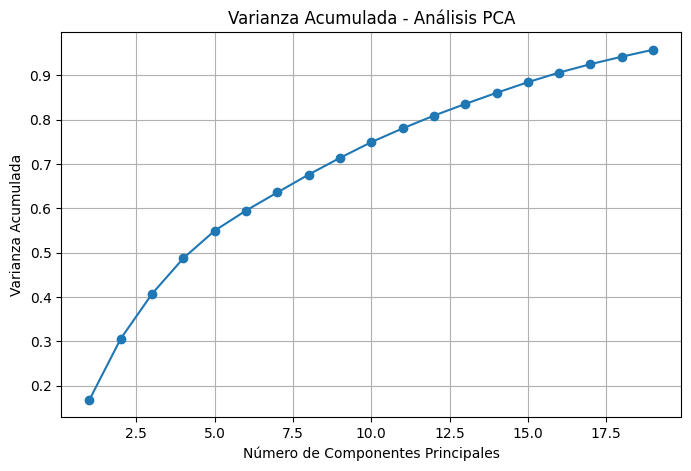

In [55]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Varianza Acumulada - Análisis PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.grid()
plt.show()

El análisis de varianza acumulada realizado mediante el PCA muestra que, para explicar aproximadamente **el 95% de la variabilidad presente en los datos originales, es necesario conservar un total de 19 componentes principales**. Esto indica que, aunque el conjunto inicial de variables contenía redundancia e información correlacionada, la estructura de los datos es compleja y requiere un número elevado de componentes para conservar la mayor parte de la información. A partir de estos 19 componentes, se procederá a realizar el análisis de clustering, garantizando que se preserve la información esencial de los datos mientras se reduce la dimensionalidad.

## **Determinación óptima del número de clusters: Elbow Method.**
Una vez reducido el conjunto de variables mediante el Análisis de Componentes Principales (PCA), el siguiente paso consiste en **determinar el número óptimo de clusters para la segmentación de clientes**. Para ello, se aplica el Método del Codo (Elbow Method), que permite identificar el punto en el que añadir más clusters no mejora significativamente la compactación de los grupos.

El criterio se basa en analizar la inercia intra-cluster (suma de distancias de cada punto al centroide de su cluster) y localizar el punto de inflexión o "codo" en la curva.

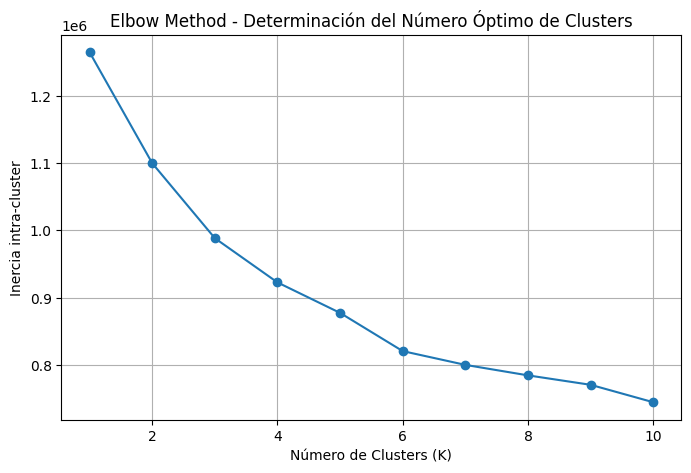

In [56]:
# Evaluación de la inercia para distintos valores de K.
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Gráfico del método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method - Determinación del Número Óptimo de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia intra-cluster')
plt.grid()
plt.show()

In [57]:
clusters = 4 # Número óptimo de clusters determinado visualmente.
print(f"El número óptimo de clusters es: {clusters}")

El número óptimo de clusters es: 4


## **Segmentación de clientes mediante K-Means.**
Una vez determinado el número óptimo de clusters mediante el Elbow Method, el siguiente paso consiste en aplicar el algoritmo K-Means para segmentar a los clientes en función de los componentes principales obtenidos con el PCA.

El objetivo de este proceso es **identificar grupos homogéneos de clientes que compartan características similares**, facilitando la elaboración de estrategias personalizadas de fidelización y maximización del valor del cliente.

In [58]:
kmeans = KMeans(n_clusters=clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_pca)

### **Análisis e interpretación de los clusters.**
Este análisis tiene como objetivo **identificar las características distintivas** de cada cluster, permitiendo comprender las diferencias entre los perfiles segmentados. Para ello, se examinará el tamaño de cada grupo y se calcularán estadísticas descriptivas de las variables originales por cluster.

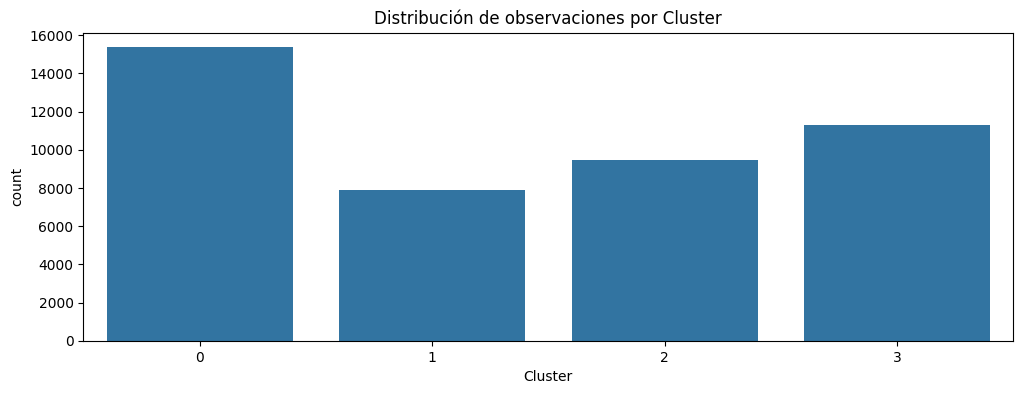

In [59]:
plt.figure(figsize=(12, 4))
sns.countplot(x='Cluster', data=df)
plt.title('Distribución de observaciones por Cluster')
plt.show()

Esta distribución homogénea es un indicador positivo, ya que evita la aparición de clusters residuales o poco representativos. Además, garantiza que cada grupo identificado tiene un volumen significativo de clientes, lo que facilita el análisis posterior y la implementación de estrategias de negocio diferenciadas para cada segmento.

In [60]:
df.groupby('Cluster').mean()

,Edad,RENTA_MEDIA_ESTIMADA,ENCUESTA_ZONA_CLIENTE_VENTA,ENCUESTA_CLIENTE_ZONA_TALLER,total_quejas,lat,lon,numventas,pvp_medio,coste_medio_sin_impuestos,descuento_medio,avg_revisiones,ratio_edad_rev,km_rev,km_rev_max,dias_ultima_rev_max,avg_dias_taller,ratio_en_garantia,lead_algunavez,lead_compra,margenbruto_pu,margen_total,margen_pu,edad_ultimocoche,edad_promedio_coches,ingresos_totales,impuestos_totales,dias_relacion,avg_dias_produccion_venta,churn_estimado,retencion_estimado,CLTV_1_anio,CLTV_2_anios,CLTV_3_anios,CLTV_4_anios,CLTV_5_anios
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,45.988284,19788.683806,54.520112,57.158878,0.137074,-2.808953,39.794117,1.200859,23297.012236,1262.114098,-1922.581880,0.000846,0.026360,1781.242385,3597.620281,14.038336,1.890496,0.997722,0.596980,0.146902,8298.673302,4822.075050,4078.782705,0.778899,0.698256,27986.384080,0.0,67.294324,102.421179,0.382246,0.617754,2382.959532,3882.929854,4872.418760,5545.995755,6014.798273
1,38.321708,24956.436063,69.697372,73.588324,0.183978,-2.884250,40.075208,1.211777,24015.556356,1276.656305,-1962.792772,2.738817,15.811347,100656.979025,110610.805661,302.836240,3.723793,0.040814,0.593884,0.137225,7862.668361,3687.366330,3095.130094,4.301112,4.090085,29073.782032,0.0,155.797195,84.194718,0.076518,0.923482,2659.932463,4993.502602,7071.284586,8941.182360,10637.163258
2,40.221717,19273.735568,53.483823,55.425671,0.182280,-3.024022,39.599758,1.802390,23268.550962,1249.585430,-1929.259569,0.501269,16.696659,20889.645485,36850.681328,324.850708,1.990518,0.084902,0.720660,0.211990,8357.142200,7394.780322,4206.868729,4.235568,3.312996,42107.710933,0.0,668.167160,88.491647,0.757032,0.242968,908.851843,1344.535605,1583.765492,1727.302726,1819.509907
3,43.917116,24751.651674,68.166652,72.746046,0.215251,-2.851537,39.990203,1.145357,23874.349386,1248.909958,-1980.596448,1.230980,38.990810,43363.527878,46552.893700,152.862154,5.291781,0.995140,0.588230,0.146417,7828.987140,3612.782970,3168.925775,1.583635,1.509705,27346.139436,0.0,58.301670,102.513917,0.075036,0.924964,2733.996791,5126.400319,7243.305348,9132.991661,10831.729277


### **Visualización de los clusters.**
Una vez realizada la segmentación de los clientes mediante K-Means, es necesario representar gráficamente los resultados para facilitar la interpretación y comprensión de la distribución de los grupos identificados. Para ello, se visualizarán los clientes proyectados sobre los dos primeros componentes principales obtenidos mediante PCA, diferenciando los clusters asignados.

Este análisis permitirá identificar posibles solapamientos, la separación entre grupos y patrones relevantes en los datos.

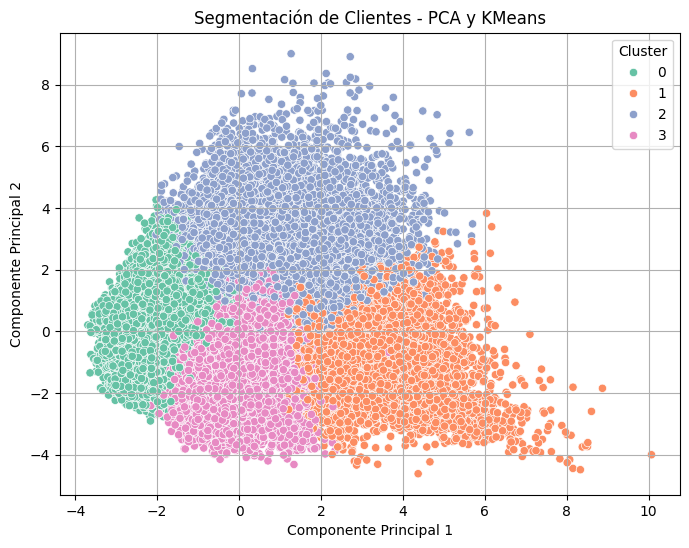

In [61]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='Set2')
plt.title('Segmentación de Clientes - PCA y KMeans')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid()
plt.legend(title='Cluster')
plt.show()

La representación muestra la distribución de los clientes en función de los dos primeros componentes principales, diferenciando los clusters asignados por el modelo K-Means. La segmentación realizada presenta una **estructura equilibrada y visualmente diferenciada**, con una clara separación entre algunos grupos y un solapamiento moderado en ciertas zonas, propio de la proyección en dos dimensiones.

In [62]:
# Añadir componentes principales al DataFrame: PCA1 y PCA2 - Para graficar posteriormente.
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

## **Análisis y perfilado de los clusters.**
En este apartado se realiza el análisis detallado de los clusters obtenidos mediante K-Means, con el objetivo de identificar las características principales de cada grupo de clientes. Para ello, se analizarán variables clave, incluyendo el **Customer Lifetime Value (CLTV) a 5 años**, así como otras métricas socioeconómicas y de comportamiento.

### **Análisis general del CLTV a 5 años por cluster.**
En este primer análisis se estudia la distribución del número de clientes y el valor medio del CLTV a 5 años en cada uno de los clusters identificados. Este análisis permitirá **evaluar si existen diferencias relevantes** en el valor potencial de los clientes por grupo y validar la utilidad de la segmentación realizada desde un punto de vista de negocio.

In [63]:
cluster_profile = df.groupby('Cluster')['CLTV_5_anios'].agg(['count', 'mean', 'std']).reset_index()
cluster_profile.columns = ['Cluster', 'Numero_Clientes', 'CLTV_5_Anios_Medio', 'CLTV_5_Anios_Desviacion']
cluster_profile

,Cluster,Numero_Clientes,CLTV_5_Anios_Medio,CLTV_5_Anios_Desviacion
0,0,15364,6014.798273,8134.742039
1,1,7914,10637.163258,16603.952784
2,2,9458,1819.509907,3589.091764
3,3,11317,10831.729277,16982.555991


**Interpretación técnica y de negocio:**
- Los **clusters 1 y 3** concentran **clientes de mayor valor potencial**, con un CLTV medio a 5 años superior a los 10.000 €. Estos grupos deberían ser considerados **prioritarios para la compañía**, orientando hacia ellos las acciones de fidelización, mantenimiento y maximización de valor.
- El **cluster 0** agrupa un volumen elevado de clientes, con un CLTV medio intermedio. Aunque no son los más rentables, representan un **segmento relevante por volumen y potencial de crecimiento**.
- El **cluster 2** presenta el CLTV más bajo, lo que indica un perfil de **clientes de bajo valor** a largo plazo. Este grupo podría ser objeto de **estrategias orientadas a mejorar su rentabilidad o reducir costes asociados**.
<br>

> El **Cluster 1** representa el grupo más rentable, mientras que el **Cluster 2** concentra clientes con un valor significativamente inferior.

**Propuesta de nombres para los clusters.**
| Cluster | Nombre | Descripción estratégica |
|------|-------------------------------|---------------------------------------------------------------|
| 0 | **Clientes Ocasionales** | Gran volumen de clientes con un CLTV medio-intermedio. Clientes estables pero no especialmente rentables. |
| 1 | **Clientes Premium** | Segmento de alto valor, con CLTV medio elevado. Clientes fidelizados y con potencial estratégico. |
| 2 | **Clientes de Bajo Potencial** | Clientes con el CLTV medio más bajo. Grupo con menor rentabilidad y con riesgo de abandono o bajo engagement. |
| 3 | **Clientes Rentables** | Segmento también de alto CLTV, aunque con menor volumen que los Premium. Clientes consolidados y rentables. |




In [64]:
cluster_names = {
    0: 'Clientes Ocasionales',
    1: 'Clientes Premium',
    2: 'Clientes de Bajo Potencial',
    3: 'Clientes Rentables'
}
df['Cluster_Nombre'] = df['Cluster'].map(cluster_names)

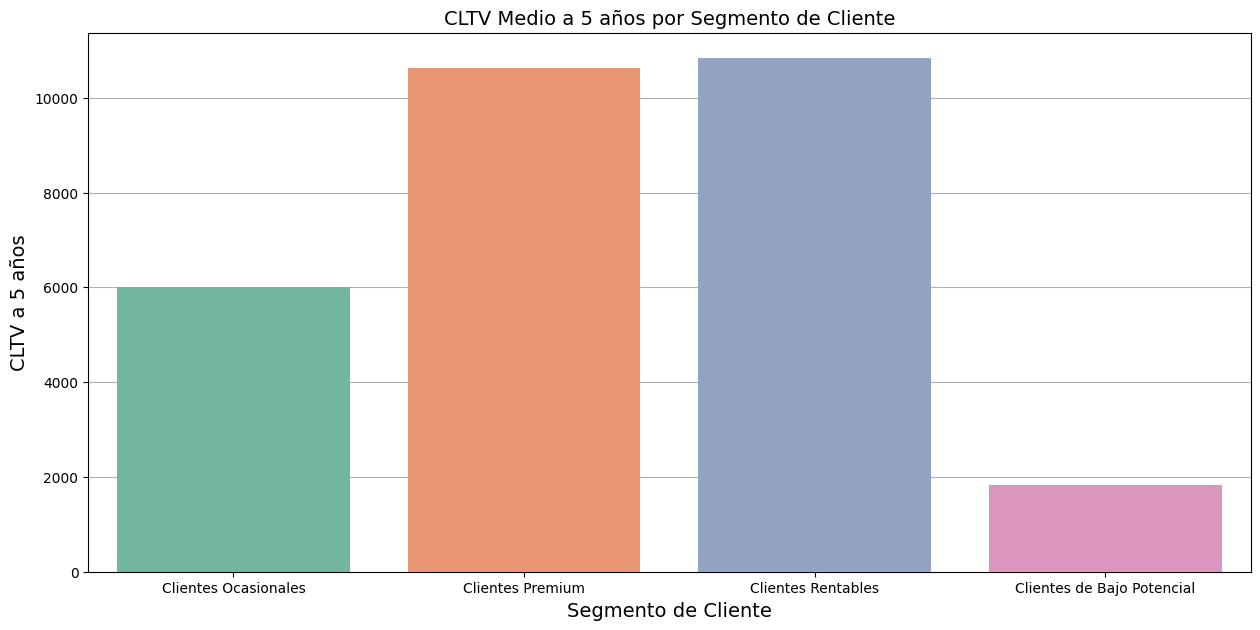

In [65]:
cltv_summary = df.groupby('Cluster_Nombre')['CLTV_5_anios'].mean().reset_index()
plt.figure(figsize=(15, 7))
sns.barplot(data=cltv_summary, x='Cluster_Nombre', y='CLTV_5_anios', palette='Set2', hue='Cluster_Nombre', zorder = 5)
plt.title('CLTV Medio a 5 años por Segmento de Cliente', fontsize=14)
plt.xlabel('Segmento de Cliente', fontsize=14)
plt.ylabel('CLTV a 5 años', fontsize=14)
plt.grid(axis='y', zorder = 0)
plt.show()

### **Análisis detallado de variables clave por cluster.**
Además de analizar el valor medio del CLTV, es fundamental **entender las características socioeconómicas y de comportamiento que definen a cada cluster**. Este perfilado detallado permite identificar patrones comunes dentro de cada grupo y obtener información clave para diseñar estrategias personalizadas. En este apartado, se analizan variables representativas: Edad, Renta media estimada,Número de ventasy Margen total.

In [66]:
# Variables clave para el perfilado.
variables_perfil = ['Edad', 'RENTA_MEDIA_ESTIMADA', 'numventas', 'margen_total', 'dias_relacion']

In [67]:
# Creación del perfil detallado por cluster.
perfil_detallado = df.groupby('Cluster_Nombre')[variables_perfil].mean().reset_index()
perfil_detallado

,Cluster_Nombre,Edad,RENTA_MEDIA_ESTIMADA,numventas,margen_total,dias_relacion
0,Clientes Ocasionales,45.988284,19788.683806,1.200859,4822.075050,67.294324
1,Clientes Premium,38.321708,24956.436063,1.211777,3687.366330,155.797195
2,Clientes Rentables,43.917116,24751.651674,1.145357,3612.782970,58.301670
3,Clientes de Bajo Potencial,40.221717,19273.735568,1.802390,7394.780322,668.167160


**Perfil de los clusters.**
| Cluster                     | Perfil Socioeconómico                             | Comportamiento Comercial                                              | Interpretación Estratégica                                            |
|-----------------------------|----------------------------------------------------|-----------------------------------------------------------------------|----------------------------------------------------------------------|
| **Clientes Ocasionales**    | Edad media elevada, renta media moderada           | Pocas compras, relación histórica corta, margen total intermedio      | Clientes estables pero con escaso vínculo; potencial de desarrollo    |
| **Clientes Premium**        | Clientes jóvenes, renta media más alta             | Compras moderadas, relación prolongada, alta capacidad adquisitiva    | Segmento estratégico prioritario para fidelización y mantenimiento   |
| **Clientes Rentables**      | Edad elevada, renta media alta                     | Pocas compras, relación reciente, margen positivo                     | Clientes rentables con potencial de crecimiento si se fidelizan      |
| **Clientes Bajo Potencial** | Edad intermedia, renta media más baja              | Alta frecuencia de compras, relación histórica muy larga, margen bajo | Clientes muy activos pero poco rentables; optimización de costes     |

El perfilado detallado de los clusters evidencia diferencias relevantes entre los segmentos, tanto en su valor económico como en sus características demográficas y de comportamiento. Esta información permitirá a la compañía diseñar estrategias diferenciadas y orientadas a:

- Fidelización y mantenimiento de los Clientes Premium y Rentables.
- Activación y desarrollo de los Clientes Ocasionales.
- Optimización de costes y evaluación de rentabilidad para los Clientes de Bajo Potencial.

In [68]:
params = urllib.parse.quote_plus(local_conn_str)
engine = sqlalchemy.create_engine(f"mssql+pyodbc:///?odbc_connect={params}")
table_name = 'client_insights_cluster'

# Guardar el DataFrame en SQL Server.
df.to_sql(table_name, con=engine, if_exists='replace', index=False)
print(f"Tabla '{table_name}' creada y poblada correctamente en SQL Server.")

Tabla 'client_insights_cluster' creada y poblada correctamente en SQL Server.


In [69]:
df.to_csv('../data/client_insights_cluster.csv', index=True)